<a href="https://colab.research.google.com/github/AvonleaFisher/Analyzing-NYC-311-Service-Requests/blob/main/Modeling_and_Interpreting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 

The aim of this section is to train a neural network that can accurately classify the agency that responded to a 311 call. In the exploratory analysis section, we saw that none of the community districts' numeric indicators were highly correlated with any of the dummy-encoded agency categories. Intuitively, one may expect the call's descriptor to be the best predictor of the responding agency, but given that the descriptors consist of natural language data, they will need to undergo additional preprocessig before being fed into a model.

In [191]:
from tensorflow.random import set_seed
set_seed(9)
import numpy as np
np.random.seed(999)

# Loading Dependencies

In [192]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re

from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout

# Importing the Data
The data used in this notebook can be accessed via the following sharable Google Drive link:

[df_final.csv](https://drive.google.com/file/d/1Jqxrz8lDY_iYYur7eJaBt9fmf-O2UqLO/view?usp=sharing)


In [193]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [194]:
path = '/content/drive/MyDrive/Colab Notebooks/df_final.csv' #change path to match your Google Drive file location
df = pd.read_csv(path, index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Assessing Model Performance

With perfectly balanced classes, a model's accuracy is acceptable if it exceeds the expected accuracy rate of simply picking a random class. With heavily imbalanced classes, however, a model's accuracy can instead be compared to that of picking the majority class. Below is the expected accuracy rate if we were to predict that all calls in a sample were responded to by the NYPD.

In [195]:
#divide count of NYPD calls by total calls and round to 2 decimal places
round(len(df[df.agency =='NYPD'])/len(df) * 100, 2) 

52.61

While the aim will be to maximize model accuracy, any classifier that is at least 53% accurate will out-perform the simple assignment of all calls to the NYPD.

# Sampling the Data 
The dataset currently consists of more than one million rows:

In [196]:
len(df)

1379786

Retrieving the training data from a representative sample, rather than the entire dataset, will save time in the training process and ideally not result in a significant decline in accuracy.

In training classification models, we'll want to ensure that complaint descriptors from every agency category are represented. This way, the model will also be able to recognize encoded descriptors that correspond to agencies that rarely receive calls. However, training a model on samples of equal length from each agency may lead to confusion when it is presented with new, imbalanced data. We'll oversample the minority classes, but ensure that the largest samples are those agencies that receive the most calls. This will allow the diversity of descriptors associated with each agency to be captured in the samples. Below, we create and print a dictionary with the class weights.

In [197]:
#create dictionary to store weights
weights_dict = {}

#loop through agency: value count pairs
for agency, count in list(zip(df.agency.value_counts().index, 
                              df.agency.value_counts().values)):
#calculate weights and update dictionary 
  weight = count/len(df)
  weights_dict[agency] = weight
weights_dict

{'DCA': 0.007849768007502613,
 'DEP': 0.057544430803037575,
 'DOB': 0.031322248522596983,
 'DOE': 0.0003138167802833193,
 'DOHMH': 0.022252001397318134,
 'DOITT': 0.00011233626084044916,
 'DOT': 0.059362103978443034,
 'DPR': 0.08357020581452486,
 'DSNY': 0.04376330822315924,
 'EDC': 0.004157891151236496,
 'HPD': 0.12691315899711986,
 'NYPD': 0.5261301390215584,
 'OSE': 0.03320152545394721,
 'TLC': 0.0035070655884318295}

In [198]:
df.agency.value_counts()

NYPD     725947
HPD      175113
DPR      115309
DOT       81907
DEP       79399
DSNY      60384
OSE       45811
DOB       43218
DOHMH     30703
DCA       10831
EDC        5737
TLC        4839
DOE         433
DOITT       155
Name: agency, dtype: int64

Next, we'll create a new dictionary with guidelines for the number of samples to be drawn from each class. The class weights are multiplied by a term that results in the largest sample, NYPD, consisting of around 60k calls.

In [199]:
n_samples_dict = {}

#loop through agency: weight pairs
for agency, weight in zip(weights_dict.keys(), weights_dict.values()):

#multiply each weight by 15**4.3 and update the dictionary
  n_samples = int(15**4.3 * weight)
  n_samples_dict[agency] = n_samples

In [200]:
n_samples_dict

{'DCA': 895,
 'DEP': 6564,
 'DOB': 3573,
 'DOE': 35,
 'DOHMH': 2538,
 'DOITT': 12,
 'DOT': 6771,
 'DPR': 9533,
 'DSNY': 4992,
 'EDC': 474,
 'HPD': 14477,
 'NYPD': 60018,
 'OSE': 3787,
 'TLC': 400}

The below function returns weighted samples of an agency that's passed in.

In [201]:
def get_weighted_sample(agency):
  
  """Takes in an agency name as a string, and creates a subset with all rows
     with a match in the agency column. Returns a weighted sample of call data
     associated with that agency, based on the values in n_samples_dict."""

  agency_subset = df[df.agency == agency]

  n_samples = n_samples_dict[agency]
  
  weighted_sample = agency_subset.sample(n=n_samples, random_state=9)

  return weighted_sample

The function is applied below to each unique agency to create a dataframe of samples, and the dataframe is appended to the list 'samples.' These are conatenated in 'weighted_df' and the index is reset.

In [202]:
samples = []

for agency in df.agency.unique():
  samples.append(get_weighted_sample(agency))

In [203]:
weighted_df = pd.concat(samples)
weighted_df.reset_index(inplace=True)

In [204]:
weighted_df

,index,created_date,complaint_type,agency,community_board,latitude,longitude,descriptor,borough,day,month,day_of_week,hour,count_hosp_clinic,count_libraries,count_parks,count_public_schools,crime_per_1000,female_20_24,female_25_29,female_30_34,female_35_39,female_40_44,female_45_49,female_50_54,female_55_59,female_60_64,male_15_19,male_20_24,male_30_34,male_40_44,male_45_49,male_50_54,male_55_59,male_60_64,under18_rate,over65_rate,lots_total,lots_vacant,pct_white_nh,pct_black_nh,pct_asian_nh,pct_other_nh,pct_hispanic,mean_commute,pop_change_00_10,pct_clean_strts,unemployment,poverty_rate,lep_rate_boro,pct_hh_rent_burd
0,383700,2020-10-02 10:07:39,General Construction/Plumbing,DOB,7 BROOKLYN,40.638071,-74.007711,working contrary to stop work order,BROOKLYN,2020-10-02,10,4,10,32,2,4,21,8.3,3.0,4.9,4.6,4.2,3.4,3.4,3.2,2.4,2.4,2.3,2.8,5.0,3.8,3.3,3.3,2.6,2.2,24.0,10.3,13315,177,24.4,2.6,31.3,1.9,39.8,42.9,0.05,92.6,3.8,27.9,23.6,48.1
1,164754,2020-09-15 11:47:20,Elevator,DOB,4 MANHATTAN,40.752111,-74.004645,elevator multiple devices on property,MANHATTAN,2020-09-15,9,1,11,38,2,7,29,18.1,4.0,7.2,6.4,3.8,3.0,2.9,2.3,2.7,2.7,1.1,3.3,7.2,4.8,3.9,3.6,3.7,3.1,8.2,13.4,3417,70,59.1,5.2,17.2,3.0,15.5,26.7,0.18,95.6,3.5,11.3,15.8,33.9
2,1301458,2020-07-02 15:02:08,General Construction/Plumbing,DOB,6 BROOKLYN,40.676215,-74.008818,building shaking vibrating structural stability,BROOKLYN,2020-07-02,7,3,15,18,4,8,24,7.8,2.4,5.3,6.7,5.6,4.3,3.5,2.8,2.6,2.3,1.8,1.3,5.8,4.4,3.9,2.7,2.4,2.0,21.2,10.4,13799,406,64.1,7.2,7.0,5.4,16.3,38.4,0.01,95.9,4.0,9.6,23.6,28.8
3,661127,2020-08-29 15:41:01,Building/Use,DOB,12 QUEENS,40.696722,-73.761430,illegal conversion of residential building space,QUEENS,2020-08-29,8,5,15,34,9,12,46,11.2,3.6,4.1,3.6,3.6,3.2,3.8,4.0,3.7,3.2,3.0,3.5,3.4,2.8,3.0,3.5,3.1,2.7,22.4,13.3,41418,1189,1.8,61.8,12.6,7.9,15.9,49.0,0.01,94.9,5.9,19.0,28.8,46.9
4,252987,2020-06-04 13:20:26,Covid-19 Non-Essential Construction,DOB,11 BROOKLYN,40.600670,-73.982837,construction,BROOKLYN,2020-06-04,6,3,13,9,2,2,21,5.4,2.8,3.8,3.9,3.5,3.6,3.4,3.5,3.3,3.1,2.4,2.9,3.9,3.4,3.2,3.4,3.3,2.8,21.3,15.6,21821,150,40.2,1.0,40.8,2.1,15.9,46.6,0.06,93.9,4.1,22.5,23.6,49.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114064,1003068,2020-09-29 14:16:21,Linknyc,DOITT,1 MANHATTAN,40.715836,-74.002832,damaged defective,MANHATTAN,2020-09-29,9,1,14,10,2,13,19,6.8,3.9,7.2,6.5,4.7,3.6,2.9,2.3,2.4,2.6,1.8,2.8,6.3,3.6,3.6,2.7,2.7,2.7,12.7,12.8,1461,25,72.2,2.2,15.5,3.6,6.5,25.4,0.77,95.4,2.8,8.8,15.8,30.1
114065,877336,2020-07-25 11:52:58,Public Payphone Complaint,DOITT,3 QUEENS,40.751321,-73.862459,graffiti litter on phone,QUEENS,2020-07-25,7,5,11,10,4,3,13,8.4,3.0,3.9,4.2,3.9,3.4,3.2,2.9,2.7,2.5,2.5,3.1,4.8,4.4,3.9,3.4,3.1,1.9,22.2,12.7,14658,225,10.4,5.0,16.5,1.5,66.6,42.9,0.01,94.3,3.5,24.0,28.8,53.4
114066,171680,2020-11-17 16:49:12,Linknyc,DOITT,4 MANHATTAN,40.743605,-73.999726,damaged defective,MANHATTAN,2020-11-17,11,1,16,38,2,7,29,18.1,4.0,7.2,6.4,3.8,3.0,2.9,2.3,2.7,2.7,1.1,3.3,7.2,4.8,3.9,3.6,3.7,3.1,8.2,13.4,3417,70,59.1,5.2,17.2,3.0,15.5,26.7,0.18,95.6,3.5,11.3,15.8,33.9
114067,306584,2020-06-18 13:35:15,Public Payphone Complaint,DOITT,5 MANHATTAN,40.763025,-73.978139,no dial tone,MANHATTAN,2020-06-18,6,3,13,23,7,3,13,29.4,4.0,7.2,6.4,3.8,3.0,2.9,2.3,2.7,2.7,1.1,3.3,7.2,4.8,3.9,3.6,3.7,3.1,8.2,13.4,3018,109,59.1,5.2,17.2,3.0,15.5,26.7,0.17,94.4,3.5,11.3,15.8,33.9


In order for the model to be tested on new data, it should have exposure to every unique descriptor in the dataset. The below code creates a list of every item in the original dataframe's unique descriptors that is not found in the sample dataframe.

In [205]:
descriptors_not_in_sample = []

#update above list with descriptors that aren't in the sample 
for i in df.descriptor.unique():
  if i not in weighted_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

len(descriptors_not_in_sample)

168

The list above captures many of the less common descriptors that were not captured in the sample data, including most descriptors associated with minority agencies. Below, we create a dataframe with all calls that match these descriptors and concatenate them with the weighted sample dataframe.

In [206]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]

In [207]:
weighted_df = pd.concat([weighted_df,
                         descriptors_not_in_sample_df])
weighted_df.reset_index(inplace=True)

In [208]:
#confirm that the number of unique descriptors is the same for both dataframes
len(weighted_df.descriptor.unique()) == len(df.descriptor.unique())

True

The classes remain imbalanced, but no agency is represented by only a handful of samples, as would have been the case with simple random sampling:

In [19]:
weighted_df.agency.value_counts()

NYPD     60042
HPD      14521
DPR       9556
DOT       6999
DEP       6684
DSNY      5022
OSE       3787
DOB       3618
DOHMH     2675
DCA        978
EDC        474
TLC        412
DOE         53
DOITT       37
Name: agency, dtype: int64

# Keras Neural Network

## Preparing the Training and Test Data

Using the dataframe of weighted samples, we assign 'X' to the descriptor column and 'y' to the agency column. 

In [209]:
X = weighted_df.descriptor
y = weighted_df.agency

The [Keras Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) `fit_on_texts()` method, used below, "updates internal vocabulary based on a list of texts." In this case, the list of texts is all descriptors in the weighted sample. The `texts_to_matrix()` method converts the list of texts to a NumPy matrix. Specifying the mode "binary" means that only the presence or absence of each item in the tokenizer's vocabulary will be accounted for in the matrix.

In [210]:
descriptors = X
tokenizer = Tokenizer() 

tokenizer.fit_on_texts(descriptors) 
descriptor_onehot = tokenizer.texts_to_matrix(descriptors, mode='binary')
word_index = tokenizer.word_index

The word index is a dictionary that contains words in the tokenizer's vocabulary as keys, and integers that correspond to the keys' frequency rank as values. The first ten items of the dictionary are printed below, and we can see that the most frequent words have the lowest values. The highest value in the dictionary is 1114.

In [211]:
print(list(word_index.items())[0:10])
print('Max:', max(word_index.values()))

[('music', 1), ('loud', 2), ('party', 3), ('access', 4), ('no', 5), ('blocked', 6), ('hydrant', 7), ('truck', 8), ('car', 9), ('in', 10)]
Max: 1114


The content and shape of the one-hot encoded descriptors are displayed below.

In [212]:
display(descriptor_onehot)

print('Shape:', descriptor_onehot.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Shape: (114858, 1115)


The number of rows is the same as the number of rows in X, and correspond to an individual call:

In [213]:
X.shape

(114858,)

Each column corresponds to one of 1,110 words in the tokenizer's vocabulary. If the word for a column is present in a given call's descriptor, its value at the call's corresponding row will be '1.' Otherwise, it will be '0.'

The label encoder used below assigns a unique integer to each of the categories in the agency column. The [keras.utils.to_categorical
](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) method "converts a class vector (integers) to binary class matrix."

In [214]:
agency = y

le = preprocessing.LabelEncoder() 
le.fit(agency)
agency_cat = le.transform(agency)  
agency_onehot = to_categorical(agency_cat)

Let's examine the content and shape of the encoded agency data:

In [26]:
display(agency_onehot)
print('Shape:', agency_onehot.shape)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Shape: (114858, 14)


Each row corresponds to a call, and each column corresponds to an agency. The value in a given cell indicates whether the agency in its column either responded ('1'), or did not respond ('0'), to the call in its row.

Now that both X and y have been encoded, we'll create a random split of training and test data.

In [215]:
test, train, label_test, label_train = train_test_split(descriptor_onehot, agency_onehot, test_size=.1, random_state=6)

## Baseline Model

We'll start with a baseline model before writing a function to assess how different parameters affect the model's performance. For all of the models, we'll use the "categorical crossentropy" loss function, which is appropriate for multiclass classification. Accuracy will also be the performance metric used for each model, but our interpretation of the accuracy should be informed by the large number of classes and significant class imbalance.

In [28]:
model1 = models.Sequential()

model1.add(layers.Dense(50, activation='relu', input_shape=(test.shape[1],)))
model1.add(layers.Dense(25, activation='relu'))
model1.add(layers.Dense(14, activation='softmax'))


opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])

To avoid overfitting the model to the training data, we'll add the `validation_split` parameter, and an early stopping callback that monitors validation loss, to our fit function.

In [29]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model1.fit(train,
                    label_train,
                    validation_split=0.20,
                    epochs=62,
                    batch_size=32,
                    callbacks=[es])

Epoch 1/62
288/288 [==============================] - 1s 3ms/step - loss: 2.5534 - acc: 0.4877 - val_loss: 2.4941 - val_acc: 0.5109
Epoch 2/62
288/288 [==============================] - 1s 2ms/step - loss: 2.4278 - acc: 0.5215 - val_loss: 2.3713 - val_acc: 0.5109
Epoch 3/62
288/288 [==============================] - 1s 2ms/step - loss: 2.3006 - acc: 0.5215 - val_loss: 2.2430 - val_acc: 0.5109
Epoch 4/62
288/288 [==============================] - 1s 2ms/step - loss: 2.1633 - acc: 0.5215 - val_loss: 2.1039 - val_acc: 0.5109
Epoch 5/62
288/288 [==============================] - 1s 2ms/step - loss: 2.0177 - acc: 0.5215 - val_loss: 1.9634 - val_acc: 0.5109
Epoch 6/62
288/288 [==============================] - 1s 2ms/step - loss: 1.8843 - acc: 0.5215 - val_loss: 1.8488 - val_acc: 0.5109
Epoch 7/62
288/288 [==============================] - 1s 2ms/step - loss: 1.7839 - acc: 0.5215 - val_loss: 1.7688 - val_acc: 0.5109
Epoch 8/62
288/288 [==============================] - 1s 2ms/step - loss: 1.

Let's look at the model's loss and accuracy score.

In [30]:
results = model1.evaluate(test, label_test, batch_size=32)

3231/3231 [==============================] - 5s 2ms/step - loss: 0.9842 - acc: 0.6742


The function below plots the model's loss and accuracy curves, which will provide a better visual sense of how the values for these metrics changed as the number of epochs increased.

In [31]:
def plot_loss_acc(history):
 
  """Takes in a Keras history object and returns a 15*6 figure displaying the 
     model's loss and accuracy curves."""


  fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(15, 6))

  ax_font = {'fontsize': 12, 'family': 'serif', 
             'color': '#58508d', 'weight': 'bold'}
  title_font = {'fontsize': 14, 'family': 'serif',
                'color': '#58508d', 'weight': 'bold'}


  ax1.plot(history.history['acc'], color='#D8A7B1', linewidth=3)
  ax1.grid(color='g', linestyle='-', linewidth=.09)
  ax1.plot(history.history['val_acc'], color='#05234C', linewidth=3)
  ax1.set_title('Model Accuracy', fontdict=title_font)
  ax1.set_ylabel('Accuracy', fontdict=ax_font)
  ax1.set_xlabel('Number of epochs', fontdict=ax_font)
  ax1.legend(['train', 'validation'], loc='upper left')


  ax2.plot(history.history['loss'], color='#D8A7B1', linewidth=3)
  ax2.grid(color='g', linestyle='-', linewidth=.09)
  ax2.plot(history.history['val_loss'], color='#05234C', linewidth=3)
  ax2.set_title('Model Loss', fontdict=title_font)
  ax2.set_ylabel('Loss', fontdict=ax_font)
  ax2.set_xlabel('Number of epochs', fontdict=ax_font)
  ax2.legend(['train', 'validation'], loc='upper right')

  fig.show()

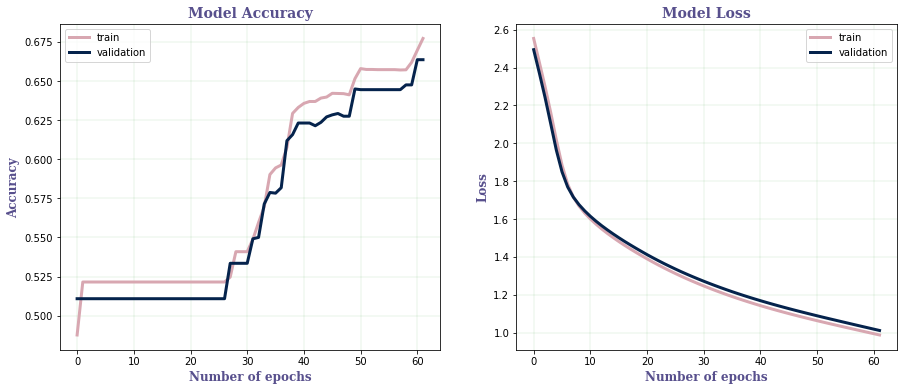

In [32]:
plot_loss_acc(history)

The accuracy score improves steadily after 30 epochs, while the loss steadily drops. We'll also create a random subset of the data that has not been resampled to evaluate the model's performance, and apply the same preprocessing steps as above.

In [33]:
random_df = df.sample(len(weighted_df), random_state=6)

In [34]:
descriptors_not_in_sample = []

for i in df.descriptor.unique():
  if i not in random_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

descriptors_not_in_sample

['bingo hall',
 'waterwaycolor ihd',
 'oil, grease in water qd',
 'safety inspectionretaining walls may ',
 'allergy information',
 'other industrial waste problem use comments for dep internal use only iz',
 'indoor pool over capacity',
 'jewelry appraiser',
 'graffiti litter on phone',
 'phone blocking sidewalk',
 'sediment',
 'snake',
 'high grass',
 'cloudy or milky, other use comments qbz',
 'push button',
 'cloudy or milky water qb',
 'absent',
 'inspection work order dob',
 'cigarette vending machine',
 'mast arm',
 'unauthorized posting of signs',
 'ped flasher',
 'enclosure cap',
 'maintenance cover',
 'booting company',
 'warning signal lamp',
 'immigration services',
 'oil spill into basin sewer  small iabs',
 'roof gutters',
 'platform condition',
 'manhole cover broken making noise sb',
 'dogs or cats not sold',
 'bent loose',
 'toxic chemical material',
 'basement',
 'gasoline spill iaa',
 'puddle on sidewalk',
 'warning signal',
 'remove debris',
 'plants odor related pr

In [35]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]
random_df = pd.concat([random_df, descriptors_not_in_sample_df])
random_df.reset_index(inplace=True)

In [36]:
random_X = random_df.descriptor
random_y = random_df.agency

In [185]:
r_descriptors = random_X
tokenizer = Tokenizer() 

tokenizer.fit_on_texts(r_descriptors) 
r_descriptor_onehot = tokenizer.texts_to_matrix(r_descriptors, mode='binary')
word_index = tokenizer.word_index

In [186]:
r_agency = random_y

le = preprocessing.LabelEncoder() 
le.fit(r_agency)
r_agency_cat = le.transform(r_agency)  
r_agency_onehot = to_categorical(r_agency_cat)

In [187]:
test_index = random.sample(range(1,10000), 1500)

r_test = r_descriptor_onehot[test_index]
r_label_test = r_agency_onehot[test_index]

In [40]:
random_results = model1.evaluate(r_descriptor_onehot, r_agency_onehot, batch_size=32)

3622/3622 [==============================] - 6s 2ms/step - loss: 1.1399 - acc: 0.6294


The model had 62% accuracy on the random sample. This score can be improved by testing different parameters in the model.

## Parameter Tuning

The function below allows us to create a model and plot its learning history, given the data and a dictionary of parameters.

In [41]:
def create_model(X_train, y_train, X_test, y_test, params):
    
    """Takes in training and test data and a dictionary with activation
       functions for each of 3 layers, an optimizer, a loss function, 
       number of epochs and batch size. Plots the model's accuracy and loss
       curves for the training and validation data, and prints the accuracy 
       score for the random sample data. Returns the history and the model."""

    model = models.Sequential()
    model.add(layers.Dense(50, activation=params['activation 1'], 
                           input_shape=(test.shape[1],)))
    model.add(layers.Dense(25, activation=params['activation 2']))
    model.add(layers.Dense(14, activation=params['activation 3']))

    opt = params['opt']
    model.compile(optimizer=opt,
              loss=params['loss'],
              metrics=['acc'])
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train,
                    y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    validation_split=0.20)
    
    print(model.summary)

    print('Test Accuracy:')
    model.evaluate(X_test, y_test, batch_size=params['batch_size'])
    
    print('Random Sample Accuracy:')
    model.evaluate(r_test, r_label_test, batch_size=params['batch_size'])
    
    plot_loss_acc(history)
    
    return history, model

We'll use the function to test out several different sets of parameters, stored in a dictionary as shown below.

In [42]:
model2_params = {'activation 1': 'relu', 
                 'activation 2': 'softmax', 
                 'activation 3': 'softmax', 
                 'opt': keras.optimizers.Adam(lr=0.0001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 75, 
                 'batch_size': 16, 
                 }

Epoch 1/75
575/575 [==============================] - 1s 2ms/step - loss: 2.5713 - acc: 0.2788 - val_loss: 2.4859 - val_acc: 0.5113
Epoch 2/75
575/575 [==============================] - 1s 2ms/step - loss: 2.3708 - acc: 0.5215 - val_loss: 2.2639 - val_acc: 0.5109
Epoch 3/75
575/575 [==============================] - 1s 2ms/step - loss: 2.1587 - acc: 0.5215 - val_loss: 2.0840 - val_acc: 0.5109
Epoch 4/75
575/575 [==============================] - 1s 2ms/step - loss: 2.0064 - acc: 0.5512 - val_loss: 1.9529 - val_acc: 0.5527
Epoch 5/75
575/575 [==============================] - 1s 2ms/step - loss: 1.8843 - acc: 0.5705 - val_loss: 1.8416 - val_acc: 0.5748
Epoch 6/75
575/575 [==============================] - 1s 2ms/step - loss: 1.7787 - acc: 0.6084 - val_loss: 1.7449 - val_acc: 0.6449
Epoch 7/75
575/575 [==============================] - 1s 2ms/step - loss: 1.6856 - acc: 0.6911 - val_loss: 1.6580 - val_acc: 0.6989
Epoch 8/75
575/575 [==============================] - 1s 2ms/step - loss: 1.

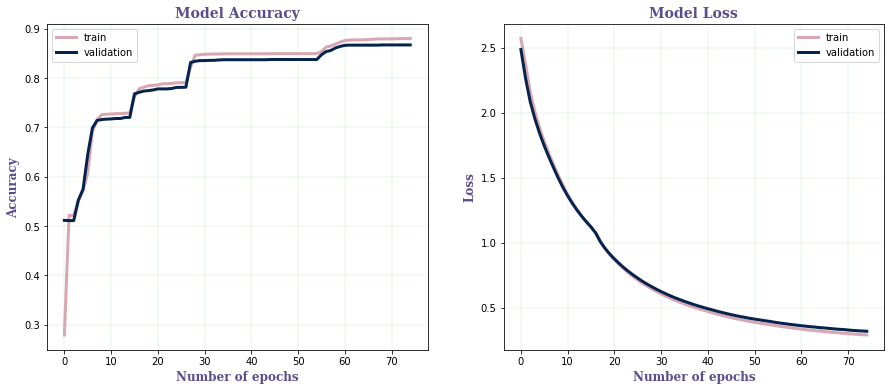

In [43]:
model2_history, model2 = create_model(train, label_train, test, label_test, model2_params)

In [44]:
model3_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.01),
                 'loss': 'categorical_crossentropy',
                 'epochs': 45, 
                 'batch_size': 16, 
                 }

Epoch 1/45
575/575 [==============================] - 1s 2ms/step - loss: 1.7529 - acc: 0.5126 - val_loss: 1.3868 - val_acc: 0.5283
Epoch 2/45
575/575 [==============================] - 1s 2ms/step - loss: 1.1958 - acc: 0.5902 - val_loss: 1.0883 - val_acc: 0.6401
Epoch 3/45
575/575 [==============================] - 1s 2ms/step - loss: 0.9647 - acc: 0.7132 - val_loss: 0.9049 - val_acc: 0.7398
Epoch 4/45
575/575 [==============================] - 1s 2ms/step - loss: 0.8066 - acc: 0.7781 - val_loss: 0.7607 - val_acc: 0.8007
Epoch 5/45
575/575 [==============================] - 1s 2ms/step - loss: 0.6704 - acc: 0.8287 - val_loss: 0.6326 - val_acc: 0.8473
Epoch 6/45
575/575 [==============================] - 1s 2ms/step - loss: 0.5508 - acc: 0.8648 - val_loss: 0.5239 - val_acc: 0.8677
Epoch 7/45
575/575 [==============================] - 1s 2ms/step - loss: 0.4542 - acc: 0.8863 - val_loss: 0.4400 - val_acc: 0.8960
Epoch 8/45
575/575 [==============================] - 1s 2ms/step - loss: 0.

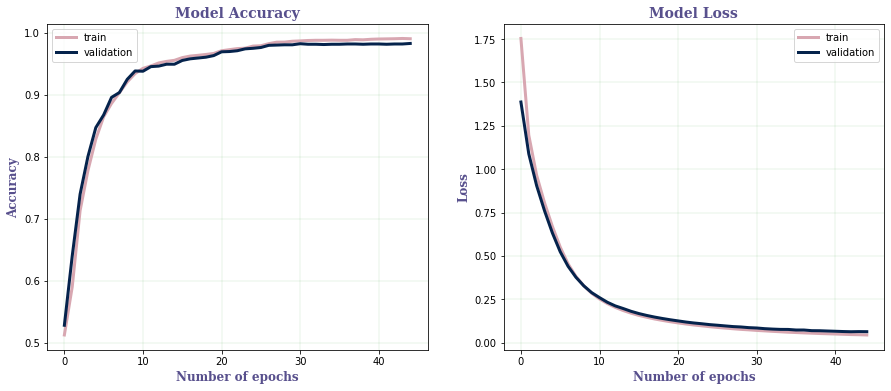

In [45]:
model3_history, model3 = create_model(train, label_train, test, label_test, model3_params)

In [216]:
model4_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 250, 
                 'batch_size': 50, 
                 }

Epoch 1/250
184/184 [==============================] - 1s 3ms/step - loss: 2.5759 - acc: 0.4680 - val_loss: 2.5382 - val_acc: 0.5109
Epoch 2/250
184/184 [==============================] - 0s 2ms/step - loss: 2.4958 - acc: 0.5215 - val_loss: 2.4597 - val_acc: 0.5109
Epoch 3/250
184/184 [==============================] - 0s 2ms/step - loss: 2.4155 - acc: 0.5215 - val_loss: 2.3818 - val_acc: 0.5109
Epoch 4/250
184/184 [==============================] - 0s 2ms/step - loss: 2.3352 - acc: 0.5215 - val_loss: 2.3019 - val_acc: 0.5109
Epoch 5/250
184/184 [==============================] - 0s 2ms/step - loss: 2.2511 - acc: 0.5215 - val_loss: 2.2175 - val_acc: 0.5109
Epoch 6/250
184/184 [==============================] - 0s 2ms/step - loss: 2.1621 - acc: 0.5215 - val_loss: 2.1282 - val_acc: 0.5109
Epoch 7/250
184/184 [==============================] - 0s 2ms/step - loss: 2.0686 - acc: 0.5215 - val_loss: 2.0364 - val_acc: 0.5109
Epoch 8/250
184/184 [==============================] - 0s 2ms/step - 

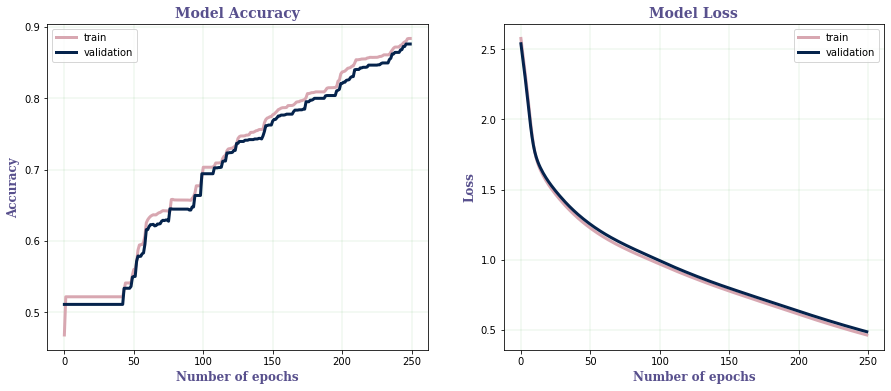

In [217]:
model4_history, model4 = create_model(train, label_train, test, label_test, model4_params)

In [48]:
model5_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 270, 
                 'batch_size': 40, 
                 }

Epoch 1/270
230/230 [==============================] - 1s 3ms/step - loss: 2.5883 - acc: 0.3399 - val_loss: 2.5324 - val_acc: 0.5096
Epoch 2/270
230/230 [==============================] - 0s 2ms/step - loss: 2.4650 - acc: 0.5212 - val_loss: 2.4024 - val_acc: 0.5109
Epoch 3/270
230/230 [==============================] - 0s 2ms/step - loss: 2.3273 - acc: 0.5215 - val_loss: 2.2667 - val_acc: 0.5109
Epoch 4/270
230/230 [==============================] - 1s 2ms/step - loss: 2.1859 - acc: 0.5215 - val_loss: 2.1280 - val_acc: 0.5109
Epoch 5/270
230/230 [==============================] - 1s 2ms/step - loss: 2.0423 - acc: 0.5215 - val_loss: 1.9900 - val_acc: 0.5109
Epoch 6/270
230/230 [==============================] - 0s 2ms/step - loss: 1.9058 - acc: 0.5215 - val_loss: 1.8670 - val_acc: 0.5109
Epoch 7/270
230/230 [==============================] - 1s 2ms/step - loss: 1.7925 - acc: 0.5215 - val_loss: 1.7736 - val_acc: 0.5109
Epoch 8/270
230/230 [==============================] - 0s 2ms/step - 

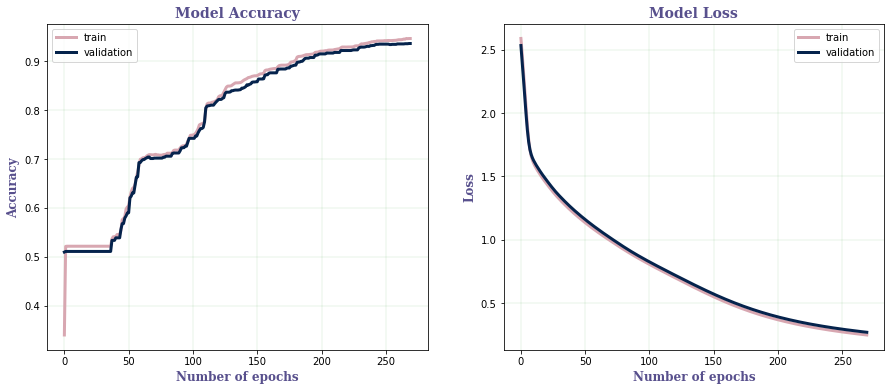

In [49]:
model5_history, model5 = create_model(train, label_train, test, label_test, model5_params)

In [50]:
model6_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 170, 
                 'batch_size': 30, 
                 }

Epoch 1/170
307/307 [==============================] - 1s 2ms/step - loss: 2.5912 - acc: 0.3847 - val_loss: 2.5368 - val_acc: 0.5117
Epoch 2/170
307/307 [==============================] - 1s 2ms/step - loss: 2.4790 - acc: 0.5215 - val_loss: 2.4241 - val_acc: 0.5109
Epoch 3/170
307/307 [==============================] - 1s 2ms/step - loss: 2.3600 - acc: 0.5215 - val_loss: 2.3012 - val_acc: 0.5109
Epoch 4/170
307/307 [==============================] - 1s 2ms/step - loss: 2.2257 - acc: 0.5215 - val_loss: 2.1648 - val_acc: 0.5109
Epoch 5/170
307/307 [==============================] - 1s 2ms/step - loss: 2.0840 - acc: 0.5215 - val_loss: 2.0258 - val_acc: 0.5109
Epoch 6/170
307/307 [==============================] - 1s 2ms/step - loss: 1.9439 - acc: 0.5215 - val_loss: 1.8952 - val_acc: 0.5109
Epoch 7/170
307/307 [==============================] - 1s 2ms/step - loss: 1.8204 - acc: 0.5215 - val_loss: 1.7892 - val_acc: 0.5109
Epoch 8/170
307/307 [==============================] - 1s 2ms/step - 

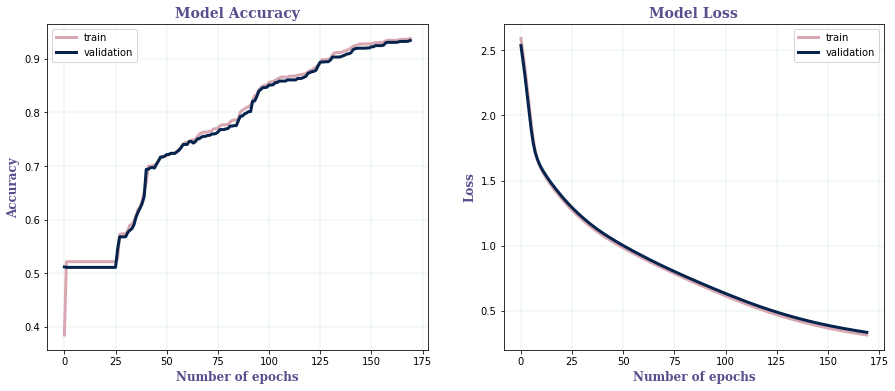

In [51]:
model6_history, model6 = create_model(train, label_train, test, label_test, model6_params)

Model 6 had the best performance on the random sample, with about 74% accuracy.

## Confusion Matrix

We'll create a confusion matrix to get a fuller sense of how the model performed on the random sample.  

In [218]:
label_preds = model4.predict_classes(r_descriptor_onehot)
label_preds_onehot = to_categorical(label_preds)

In [220]:
cf_matrix = confusion_matrix(r_agency_cat, label_preds, normalize='true')

Text(0.5, 96.0, 'Predicted Agency')

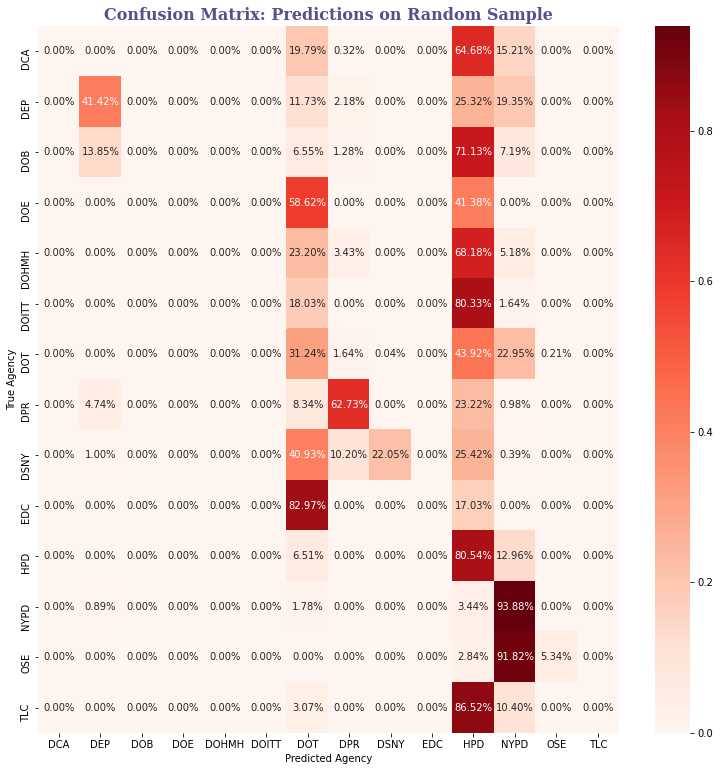

In [222]:
plt.figure(figsize=(13, 13))
plt.title('Confusion Matrix: Predictions on Random Sample', 
          fontdict={'fontsize': 16, 'family': 'serif', 'color': '#58508d', 'weight': 'bold'})

sns.heatmap(cf_matrix, annot=True, xticklabels=le.classes_, yticklabels=le.classes_,
            fmt='.2%', cmap='Reds')
plt.ylabel('True Agency')
plt.xlabel('Predicted Agency')

The model correctly classified 93.8% of NYPD calls, 80.5% of HBD calls, and 62.7% of DPR calls, but still mis-classifies many calls in the minority classes.

# LSTM Model

Long Short Term Memory (LSTM) recurrent neural network models are appropriate when the order of the input data matters. They are especially useful when working with natural language data, given that the order of words in a grouping of words can significantly change their meaning. Most of the 311 call descriptions are short, so there may be limited variation in the order of words within them. For perspective, the longest descriptor has been printed below.

In [55]:
#create dictionary and update it with each unique descriptor and its length
lengths = {} 
for descriptor in df.descriptor:
  if descriptor not in lengths:
    lengths[descriptor] = len(descriptor)

#Get descriptor with the highest length value and print it
for descriptor, length in lengths.items(): 
  if len(descriptor) == max(lengths.values()):
    print('Descriptor:', descriptor)
    print('Length:', length)

Descriptor: safety netting guard rails  damaged inadequate none  stories  feet or less
Length: 74


The longest descriptor is only 74 characters. If there is little variation in the order of descriptor words due to their short length, we may not see much improvement in an LSTM model, but possible improvement is nonetheless worth investigating.

In [73]:
descriptors = X
tokenizer = Tokenizer() 

tokenizer.fit_on_texts(descriptors) 
descriptor_onehot = tokenizer.texts_to_sequences(descriptors) 

#padding sequences ensures all sequences have the same length
descriptor_onehot = pad_sequences(descriptor_onehot) 

In [74]:
#split the test and train data again with new descriptor data
test, train, label_test, label_train = train_test_split(descriptor_onehot, 
                                                        agency_onehot, 
                                                        test_size=.1, 
                                                        random_state=6)

In [97]:
#store the shape in an object that will be used in the model's input dimensions
train_shape = train.shape

In [ ]:
#create a model using an LSTM layer, with dropout to prevent overfitting

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model = Sequential()
model.add(layers.Embedding(input_dim=train_shape[0], output_dim=100))
model.add(layers.LSTM(64, dropout=0.1, activation='relu',return_sequences=True))
model.add(layers.GRU(14, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(.2))
model.add(layers.Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

We'll fit the LSTM model with an early stopping callback. This model has a longer training time than those built in the previous section. Implementing early stopping will ensure that the model does not continue to train after its improvement with each epoch becomes insignificant.

In [168]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train, label_train, validation_data=(test, label_test), 
                    epochs=150, batch_size=30, callbacks=[early_stopping])

Epoch 1/150
383/383 [==============================] - 42s 110ms/step - loss: 2.0293 - accuracy: 0.5166 - val_loss: 1.7932 - val_accuracy: 0.5231
Epoch 2/150
383/383 [==============================] - 41s 108ms/step - loss: 1.7864 - accuracy: 0.5194 - val_loss: 1.7156 - val_accuracy: 0.5231
Epoch 3/150
383/383 [==============================] - 42s 109ms/step - loss: 1.7281 - accuracy: 0.5194 - val_loss: 1.6680 - val_accuracy: 0.5231
Epoch 4/150
383/383 [==============================] - 43s 111ms/step - loss: 1.6803 - accuracy: 0.5194 - val_loss: 1.6185 - val_accuracy: 0.5231
Epoch 5/150
383/383 [==============================] - 42s 110ms/step - loss: 1.6163 - accuracy: 0.5195 - val_loss: 1.5367 - val_accuracy: 0.5231
Epoch 6/150
383/383 [==============================] - 42s 108ms/step - loss: 1.5202 - accuracy: 0.5258 - val_loss: 1.4179 - val_accuracy: 0.5393
Epoch 7/150
383/383 [==============================] - 42s 109ms/step - loss: 1.3972 - accuracy: 0.5586 - val_loss: 1.3041 -

With the early stopping callback, the model stopped training after 91 epochs. Below, we use modified code from the `plot_acc_loss()` function to visualize the model's learning history.

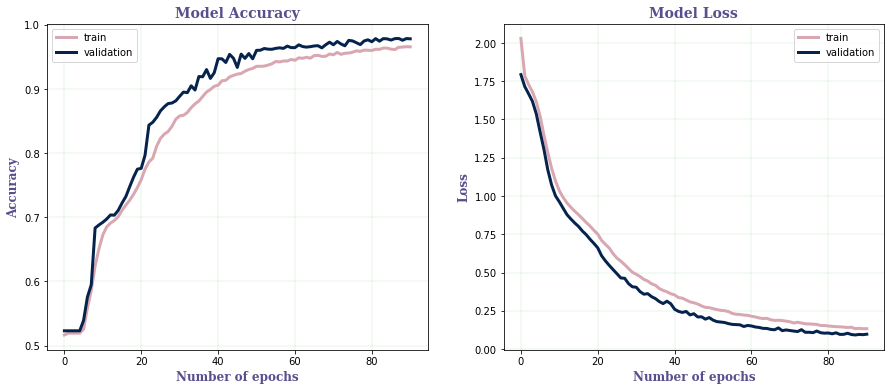

In [174]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(15, 6))

ax_font = {'fontsize': 12, 'family': 'serif', 
             'color': '#58508d', 'weight': 'bold'}
title_font = {'fontsize': 14, 'family': 'serif',
                'color': '#58508d', 'weight': 'bold'}


ax1.plot(history.history['accuracy'], color='#D8A7B1', linewidth=3)
ax1.grid(color='g', linestyle='-', linewidth=.09)
ax1.plot(history.history['val_accuracy'], color='#05234C', linewidth=3)
ax1.set_title('Model Accuracy', fontdict=title_font)
ax1.set_ylabel('Accuracy', fontdict=ax_font)
ax1.set_xlabel('Number of epochs', fontdict=ax_font)
ax1.legend(['train', 'validation'], loc='upper left')


ax2.plot(history.history['loss'], color='#D8A7B1', linewidth=3)
ax2.grid(color='g', linestyle='-', linewidth=.09)
ax2.plot(history.history['val_loss'], color='#05234C', linewidth=3)
ax2.set_title('Model Loss', fontdict=title_font)
ax2.set_ylabel('Loss', fontdict=ax_font)
ax2.set_xlabel('Number of epochs', fontdict=ax_font)
ax2.legend(['train', 'validation'], loc='upper right')

fig.show()

The model's performance on the validation data improved steadily alongside the training data across the 91 epochs. We'll now evaluate its accuracy on the random subset. 

In [183]:
#create random sample test data with padded sequences 
tokenizer.fit_on_texts(r_descriptors) 
LSTM_r_descriptor_onehot = tokenizer.texts_to_sequences(r_descriptors)
LSTM_r_descriptor_onehot = pad_sequences(LSTM_r_descriptor_onehot)

In [184]:
#evaluate accuracy
LSTM_random_results = model.evaluate(LSTM_r_descriptor_onehot, r_agency_onehot, batch_size=30)

3863/3863 [==============================] - 25s 6ms/step - loss: 1.6404 - accuracy: 0.7057


In terms of accuracy scores on the random sample, the performance of the fourth model still exceeds that of the LSTM model. Different parameters could be tested on the LSTM model, but this process would be costly given the substantial increase in training time. 

# Interpreting the Results
With 92% accuracy on the resampled test data, and 72.8% accuracy on the random subset, the fourth sequential model had the best overall performance. 

- The model correctly predicted that roughly half (49%) of calls received a response from the NYPD. 
- About 7% of predictions were correct HPD classifications.
- About 6% were correct DPR classifications. 
- About 3% were correct DOT classifications, and another 2% were correct DSNY classifications.
- Despite being trained on resampled data, the model still mis-classified the responding agency of some calls as the NYPD, HPD, or DOT. About 3% of calls, for example, were HPD but classified as DOT.

# Conclusion and Recommendations
- Similar classification models can be developed to connect individuals with non-emergency government services by directing them to the appropriate responding agency. This potential application would require training on a larger, more varied set of descriptors. The evaluation of future models may also consider metrics other than accuracy to achieve a fuller understanding of their performance.
- Agencies should be attentive to how call volume tends to change based on certain temporal, geographic, and environmental factors. Many of these changes are intuitively expected: widespread tree damage following major weather events, noise calls peaking in the middle of the night, and overall call volume remaining consistently high in the most densely populated borough, Manhattan. 
- Due to the novelty of COVID-19 regulations, complaints related to COVID-19 have appeared only recently, so particular attention should be directed toward the circumstances surrounding any future peaks.
- Given that the majority of non-emergency requests are responded to by the same agency responsible for emergency requests, local stakeholders may wish to evaluate whether the current division of labor in handling 311 calls is optimal for meeting the needs of city residents. Amid growing concerns that law enforcement officers are over-utilized for intervention in non-emergency situations, this could be a fruitful area for further inquiry.


# References 
[Hyperparameter Optimization with Keras]('https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53')